In [1]:
import numpy as np
import numba
import scipy

In [2]:
from scipy.stats import truncnorm

In [3]:
import sympy
from sympy import *  # Symbolic mathematics
from sympy.vector import *
from sympy.physics.mechanics import *
from sympy import abc, pi as Pi, I as I

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
sympy.interactive.printing.init_printing(use_latex='mathjax')

In [6]:
np.set_printoptions(precision=5, threshold=6, edgeitems=3, linewidth=75, 
                    suppress=False, nanstr=None, infstr=None, 
                    formatter=None)

In [7]:
import pandas as pd

#  Variables

In [8]:
E = ReferenceFrame('E')  # Vectors

In [9]:
m = symbols('m', positive=True)  # Mass

In [14]:
size = 2
phi = symbols('varphi_0:{}'.format(size), real=True)  # Angle [-pi, pi]
e = [cos(sym) * E.x + sin(sym) * E.y for sym in phi]  # Unit vectors
vphi = symbols('varphi', real=True)  # Angle [-pi, pi]

# Adjusting force

$\mathbf{f}^{adj} = \frac{m}{\tau^{adj}} (v_{0} \cdot \hat{\mathbf{e}} -\mathbf{v}) $

In [18]:
tau, v0, v = symbols('tau v0 v', positive=True)
f_adj = m / tau * (v0 * e[0] -  v * e[1])

In [27]:
f_adj.magnitude().simplify()

     __________________________________________
    ╱  2                                     2 
m⋅╲╱  v  - 2⋅v⋅v₀⋅cos(varphi₀ - varphi₁) + v₀  
───────────────────────────────────────────────
                       τ                       

In [28]:
_.subs(phi[0]-phi[1], vphi)

     _______________________________
    ╱  2                          2 
m⋅╲╱  v  - 2⋅v⋅v₀⋅cos(varphi) + v₀  
────────────────────────────────────
                 τ                  

# Social Force

$$
\begin{split}a &= \tilde{\mathbf{v}} \cdot \tilde{\mathbf{v}} \\
b &= -\tilde{\mathbf{x}} \cdot \tilde{\mathbf{v}} \\
c &= \tilde{\mathbf{x}} \cdot \tilde{\mathbf{x}} - \tilde{r}^{2} \\
d &= \sqrt{b^{2} - a c} \\
\tau &= \frac{b - d}{a}.\end{split}
$$

$$
\begin{split}\mathbf{f}^{soc} &= -\nabla_{\tilde{\mathbf{x}}} E(\tau) \\
&= -\nabla_{\tilde{\mathbf{x}}} \left(\frac{k}{\tau^{2}} \exp \left( -\frac{\tau}{\tau_{0}} \right) \right) \\
&= - \left(\frac{k}{a \tau^{2}}\right) \left(\frac{2}{\tau} + \frac{1}{\tau_{0}}\right) \exp\left (-\frac{\tau}{\tau_{0}}\right ) \left(\tilde{\mathbf{v}} -\frac{a \tilde{\mathbf{x}} + b \tilde{\mathbf{v}}}{d} \right),\end{split}
$$

In [35]:
x, v, r_tot = symbols('x, v, r_tot', positive=True)
x2, v2 = x * e[0], v * e[1]
a = dot(v2, v2).simplify()
b = -dot(x2, v2).simplify()
c = dot(x2, x2).simplify() - r_tot**2
d = sqrt(b**2 - a * c).simplify()

time-to-collision

In [36]:
tau = simplify((b - d) / a)

In [37]:
tau = tau.subs(phi[0]- phi[1], vphi)

In [38]:
tau

 ⎛                   ______________________________⎞ 
 ⎜                  ╱     2    2    2            2 ⎟ 
-⎝x⋅cos(varphi) + ╲╱  rₜₒₜ  + x ⋅cos (varphi) - x  ⎠ 
─────────────────────────────────────────────────────
                          v                          

tau when agents are in head-to-head collision trajectory

In [42]:
tau_min = simplify(tau.subs(vphi, Pi))

In [93]:
tau_min

-rₜₒₜ + x
─────────
    v    

In [95]:
tau_min.subs({x: R - 2 * t * v_max, v: 2 * v_max, r_tot: 2 * r})

R - 2⋅r - 2⋅t⋅vₘₐₓ
──────────────────
      2⋅vₘₐₓ      

In [96]:
simplify(_)

R             
─ - r - t⋅vₘₐₓ
2             
──────────────
     vₘₐₓ     

magnitude part of force

In [45]:
tau, tau_0 = symbols('tau tau_0', positive=True)

In [46]:
mag = -1/(a * tau**2) * (2 / tau + 1/ tau_0) * exp(-tau/tau_0)

In [47]:
mag_max = mag.subs(tau, tau_min)

In [48]:
mag_max

                   -(-rₜₒₜ + x)  
                   ───────────── 
 ⎛   2⋅v      1 ⎞       τ₀⋅v     
-⎜───────── + ──⎟⋅ℯ              
 ⎝-rₜₒₜ + x   τ₀⎠                
─────────────────────────────────
                      2          
           (-rₜₒₜ + x)           

direction part of force

In [63]:
drc = v2 - (a * x2 + b * v2) / d

In [64]:
drc

⎛                  2                   2                                      ⎞
⎜                 v ⋅x⋅cos(varphi₀) - v ⋅x⋅cos(varphi₁)⋅cos(varphi₀ - varphi₁)⎟
⎜v⋅cos(varphi₁) - ────────────────────────────────────────────────────────────⎟
⎜                             _________________________________________       ⎟
⎜                            ╱     2    2    2                       2        ⎟
⎝                        v⋅╲╱  rₜₒₜ  + x ⋅cos (varphi₀ - varphi₁) - x         ⎠ e_x + ⎛                  2                   2                                      ⎞
⎜                 v ⋅x⋅sin(varphi₀) - v ⋅x⋅sin(varphi₁)⋅cos(varphi₀ - varphi₁)⎟
⎜v⋅sin(varphi₁) - ────────────────────────────────────────────────────────────⎟
⎜                             _________________________________________       ⎟
⎜                            ╱     2    2    2                       2        ⎟
⎝                        v⋅╲╱  rₜₒₜ  + x ⋅cos (varphi₀ - varphi₁) - x         ⎠ e_y

In [65]:
drc_max = drc.subs(phi[0], Pi+phi[1])

In [66]:
drc_max

v⋅cos(varphi₁) e_x + v⋅sin(varphi₁) e_y

In [67]:
drc_mag = drc_max.magnitude().simplify()

In [68]:
drc_mag

v

total force

In [69]:
f_soc_max = drc_mag * mag_max

In [70]:
f_soc_max

                     -(-rₜₒₜ + x)  
                     ───────────── 
   ⎛   2⋅v      1 ⎞       τ₀⋅v     
-v⋅⎜───────── + ──⎟⋅ℯ              
   ⎝-rₜₒₜ + x   τ₀⎠                
───────────────────────────────────
                       2           
            (-rₜₒₜ + x)            

neighborhood

In [80]:
r, R, t, v_max = symbols("r, R, t, v_max", positive=True)

In [81]:
vals = {
    tau_0: 3,
    v: 2 * v_max,
    r_tot: 2 * r,
    x: R - 2 * t * v_max
}

In [82]:
vals

{rₜₒₜ: 2⋅r, τ₀: 3, v: 2⋅vₘₐₓ, x: R - 2⋅t⋅vₘₐₓ}

In [83]:
f_neigh_max = -f_soc_max.subs(vals)

In [84]:
f_neigh_max

                                 -(R - 2⋅r - 2⋅t⋅vₘₐₓ) 
                                 ──────────────────────
       ⎛      4⋅vₘₐₓ         1⎞          6⋅vₘₐₓ        
2⋅vₘₐₓ⋅⎜────────────────── + ─⎟⋅ℯ                      
       ⎝R - 2⋅r - 2⋅t⋅vₘₐₓ   3⎠                        
───────────────────────────────────────────────────────
                                     2                 
                 (R - 2⋅r - 2⋅t⋅vₘₐₓ)                  

In [112]:
vals2 = {
    v_max: 1.0,
    r: 0.255,
    t: 20 * 0.01
}

In [113]:
err = f_neigh_max.subs(vals2)

In [114]:
err

                ⎛1     4.0   ⎞  -0.166666666666667⋅R
2.3275444953767⋅⎜─ + ────────⎟⋅ℯ                    
                ⎝3   R - 0.91⎠                      
────────────────────────────────────────────────────
                              2                     
                    (R - 0.91)                      

In [115]:
f = lambdify(R, err, "numpy")

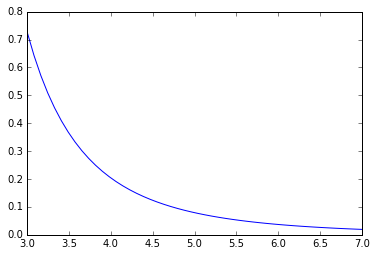

In [116]:
R2 = np.linspace(3, 7)
plt.plot(R2, f(R2))

neighsize

In [90]:
def neigh_size(R, r, rho):
    return rho * (R / r) ** 2

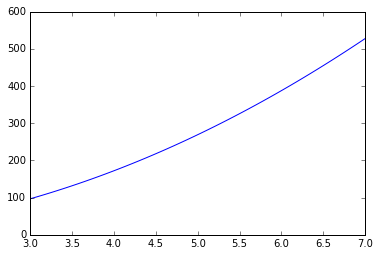

In [117]:
plt.plot(R2, neigh_size(R2, 0.255, 0.70))

# Contact Force

$$
\begin{split}\mathbf{f}^{c} = - h \cdot \left(\mu \cdot \hat{\mathbf{n}} - \kappa \cdot (\mathbf{v} \cdot \hat{\mathbf{t}}) \hat{\mathbf{t}}\right) + c_{n} \cdot (\mathbf{v} \cdot \hat{\mathbf{n}}) \hat{\mathbf{n}} , \quad h < 0\end{split}
$$